Import used libraries:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
from statsmodels.tsa.api import VAR, DynamicVAR
from statsmodels.tsa.stattools import grangercausalitytests

/Users/Malte/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# 1. Google SV and Bitcoin WAP

Import used data:

In [2]:
bitcoin_weekly_price = pd.DataFrame.from_csv("Bitcoin Weekly Price Data.csv")
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume.csv")

## Calculate first log differences

In [3]:
bitcoin_weekly_price_series = pd.Series(data=bitcoin_weekly_price["Weekly Average Price"])
bitcoin_weekly_price_series.head()

0     96.677143
1    133.834286
2    121.818571
3    113.905714
4    113.572857
Name: Weekly Average Price, dtype: float64

In [4]:
bitcoin_weekly_price_series_log = bitcoin_weekly_price_series.apply(np.log)
bitcoin_weekly_price_series_log_diff = bitcoin_weekly_price_series_log.diff()
bitcoin_weekly_price_series_log_diff = bitcoin_weekly_price_series_log_diff.drop(0)
bitcoin_weekly_price_series_log_diff.head()

1    0.325225
2   -0.094070
3   -0.067162
4   -0.002926
5    0.068116
Name: Weekly Average Price, dtype: float64

In [5]:
google_queries_series = pd.Series(data=google_queries["Relative Search Volume"])
google_queries_series.head()

0    6
1    3
2    3
3    2
4    3
Name: Relative Search Volume, dtype: int64

In [6]:
google_queries_series_log = google_queries_series.apply(np.log)
google_queries_series_log_diff = google_queries_series_log.diff()
google_queries_series_log_diff = google_queries_series_log_diff.drop(0)
google_queries_series_log_diff.head()

1   -0.693147
2    0.000000
3   -0.405465
4    0.405465
5   -0.405465
Name: Relative Search Volume, dtype: float64

Join the two dataframes:

In [7]:
a = {'Date': bitcoin_weekly_price["Date"] , 'Bitcoin WAP': bitcoin_weekly_price_series_log_diff, "Google SV" : google_queries_series_log_diff}

In [8]:
google_queries_log_diff_and_bitcoin_price_log_diff = pd.DataFrame(a)
google_queries_log_diff_and_bitcoin_price_log_diff = google_queries_log_diff_and_bitcoin_price_log_diff.drop(0)
google_queries_log_diff_and_bitcoin_price_log_diff["Date"] = pd.to_datetime(google_queries_log_diff_and_bitcoin_price_log_diff["Date"])
google_queries_log_diff_and_bitcoin_price_log_diff = google_queries_log_diff_and_bitcoin_price_log_diff.set_index("Date")
google_queries_log_diff_and_bitcoin_price_log_diff.head()

,Bitcoin WAP,Google SV
Date,,
2013-04-21,0.325225,-0.693147
2013-04-28,-0.094070,0.000000
2013-05-05,-0.067162,-0.405465
2013-05-12,-0.002926,0.405465
2013-05-19,0.068116,-0.405465


## Create the VAR Model

In [9]:
data_1 = google_queries_log_diff_and_bitcoin_price_log_diff

In [10]:
model_1 = VAR(data_1)

## Lag order selection

In [11]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -7.162       -7.133    0.0007757       -7.150
1        -7.368      -7.283*    0.0006310      -7.334*
2       -7.374*       -7.231   0.0006275*       -7.316
3        -7.367       -7.167    0.0006317       -7.287
4        -7.340       -7.082    0.0006494       -7.236
5        -7.325       -7.010    0.0006591       -7.198
6        -7.354       -6.983    0.0006400       -7.205
7        -7.334       -6.905    0.0006531       -7.161
8        -7.315       -6.829    0.0006658       -7.119
9        -7.291       -6.747    0.0006824       -7.072
10       -7.278       -6.678    0.0006909       -7.037
11       -7.257       -6.600    0.0007058       -6.993
12       -7.254       -6.539    0.0007084       -6.966
13       -7.227       -6.455    0.0007281       -6.916
14       -7.204       -6.375    0.0007454       -6.870
15       -

{'aic': 2, 'bic': 1, 'fpe': 2, 'hqic': 1}

In [12]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

Check Coefficients, contemporaneous correlation of residuals,...

In [13]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:40:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.28766
Nobs:                     259.000    HQIC:                  -7.33693
Log likelihood:           225.413    FPE:                0.000629831
AIC:                     -7.37006    Det(Omega_mle):     0.000615490
--------------------------------------------------------------------
Results for equation Bitcoin WAP
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                  0.010820         0.006361            1.701           0.090
L1.Bitcoin WAP         0.268366         0.059065            4.544           0.000
L1.Google SV           0.061920         0.023937  

## Impulse Response Analysis

In [14]:
irf_1 = results_1.irf(5)

Without orthogonalization:

In [15]:
irf_1.plot()

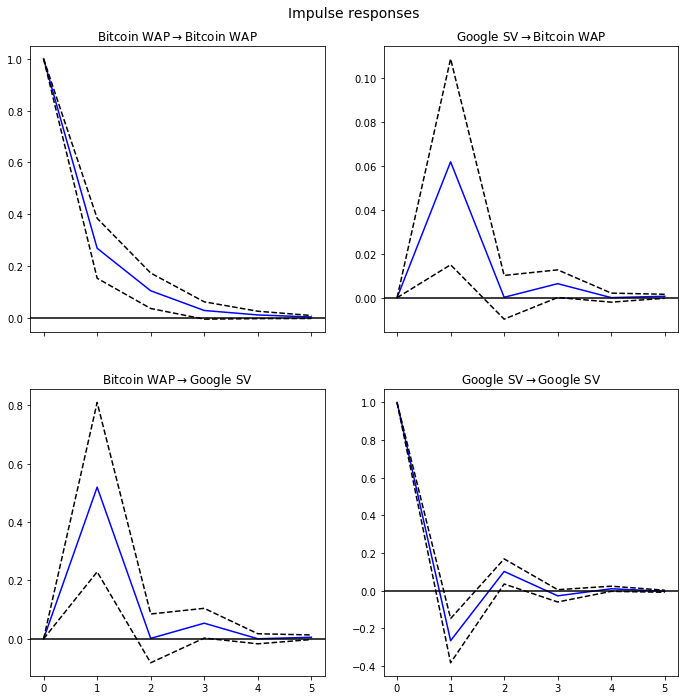

In [16]:
plt.show()

With orthogonalization: Order 1 (Bitcoin WAP - Google SV)

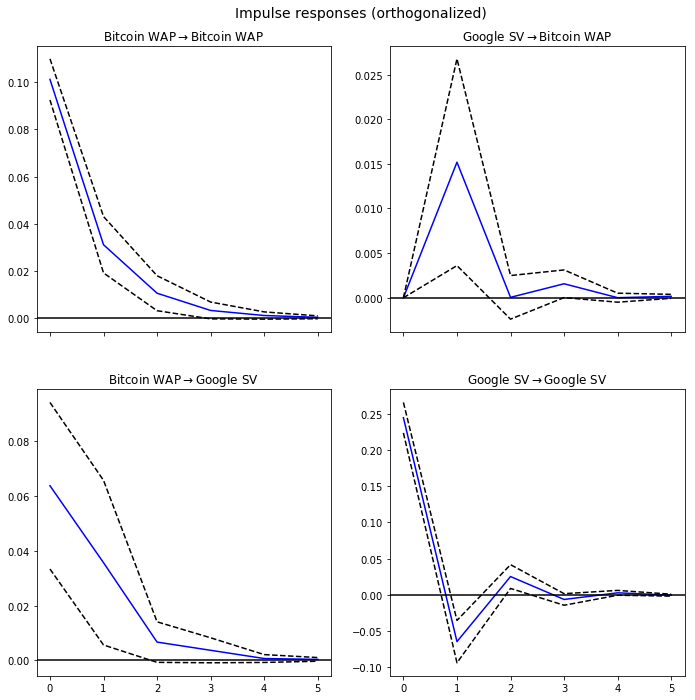

In [17]:
irf_1.plot(orth=True)
plt.show()

With orthogonalization: Order 2 (Google SV - Bitcoin WAP)

In [18]:
cols = google_queries_log_diff_and_bitcoin_price_log_diff.columns.tolist()
cols

['Bitcoin WAP', 'Google SV']

In [19]:
cols = cols[-1:] + cols[:-1]
cols

['Google SV', 'Bitcoin WAP']

In [20]:
google_queries_log_diff_and_bitcoin_price_log_diff_b = google_queries_log_diff_and_bitcoin_price_log_diff[cols]
google_queries_log_diff_and_bitcoin_price_log_diff_b.head()

,Google SV,Bitcoin WAP
Date,,
2013-04-21,-0.693147,0.325225
2013-04-28,0.000000,-0.094070
2013-05-05,-0.405465,-0.067162
2013-05-12,0.405465,-0.002926
2013-05-19,-0.405465,0.068116


In [21]:
data_1_b = google_queries_log_diff_and_bitcoin_price_log_diff_b
model_1_b = VAR(data_1_b)

In [22]:
results_1_b = model_1_b.fit(maxlags=15, ic='bic')

In [23]:
results_1_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:40:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.28766
Nobs:                     259.000    HQIC:                  -7.33693
Log likelihood:           225.413    FPE:                0.000629831
AIC:                     -7.37006    Det(Omega_mle):     0.000615490
--------------------------------------------------------------------
Results for equation Google SV
                    coefficient       std. error           t-stat            prob
---------------------------------------------------------------------------------
const                 -0.001958         0.015922           -0.123           0.902
L1.Google SV          -0.265166         0.059920           -4.425           0.000
L1.Bitcoin WAP         0.519142         0.147853    

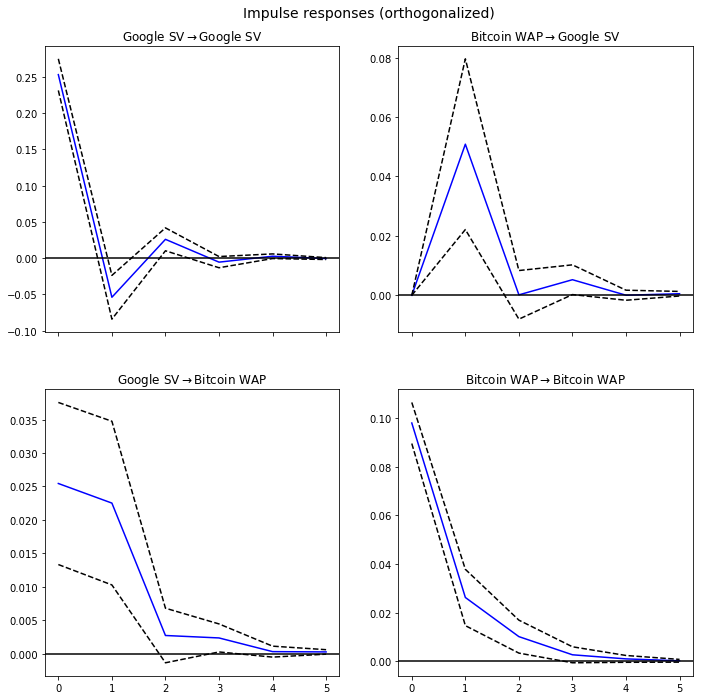

In [24]:
irf_1_b = results_1_b.irf(5)
irf_1_b.plot(orth=True)
plt.show()

## Granger Causality Test

In [25]:
results_1.test_causality("Bitcoin WAP", "Google SV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
         6.691249         3.859685            0.010  (1, 512)
H_0: ['Google SV'] do not Granger-cause Bitcoin WAP
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.0099634436411079625,
 'signif': 0.05,
 'statistic': 6.6912490036939749}

In [26]:
results_1.test_causality("Google SV", "Bitcoin WAP", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
        12.328623         3.859685            0.000  (1, 512)
H_0: ['Bitcoin WAP'] do not Granger-cause Google SV
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.00048547033846479254,
 'signif': 0.05,
 'statistic': 12.328623123778412}

# 2. Wikipedia PV and Bitcoin DP

Import used data:

In [27]:
bitcoin_daily_price = pd.DataFrame.from_csv("Bitcoin Daily Price Data.csv")
wikipedia_pageviews = pd.DataFrame.from_csv("Wikipedia Pageview Data.csv")

## Calculate first log differences

In [28]:
bitcoin_daily_price_series = pd.Series(data=bitcoin_daily_price["Daily Closing Price"])
bitcoin_daily_price_series.head()

0    257.62
1    254.54
2    255.92
3    260.20
4    271.50
Name: Daily Closing Price, dtype: float64

In [29]:
bitcoin_daily_price_series_log = bitcoin_daily_price_series.apply(np.log)
bitcoin_daily_price_series_log_diff = bitcoin_daily_price_series_log.diff()
bitcoin_daily_price_series_log_diff = bitcoin_daily_price_series_log_diff.drop(0)
bitcoin_daily_price_series_log_diff.head()

1   -0.012028
2    0.005407
3    0.016586
4    0.042512
5   -0.011074
Name: Daily Closing Price, dtype: float64

In [30]:
wikipedia_pageviews_series = pd.Series(data=wikipedia_pageviews["Pageviews"])
wikipedia_pageviews_series.head()

0    12957
1     9802
2     8307
3     8947
4     8692
Name: Pageviews, dtype: int64

In [31]:
wikipedia_pageviews_series_log = wikipedia_pageviews_series.apply(np.log)
wikipedia_pageviews_series_log_diff = wikipedia_pageviews_series_log.diff()
wikipedia_pageviews_series_log_diff = wikipedia_pageviews_series_log_diff.drop(0)
wikipedia_pageviews_series_log_diff.head()

1   -0.279050
2   -0.165488
3    0.074220
4   -0.028915
5    0.166142
Name: Pageviews, dtype: float64

Join the two dataframes:

In [32]:
b = {'Date': bitcoin_daily_price["Date"] , 'Bitcoin DP': bitcoin_daily_price_series_log_diff, "Wikipedia PV" : wikipedia_pageviews_series_log_diff}

In [33]:
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff = pd.DataFrame(b)
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff = wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff.drop(0)
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff["Date"] = pd.to_datetime(wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff["Date"])
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff = wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff.set_index("Date")
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff.columns = ["Bitcoin DP", "Wikipedia PV"]
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff.head()

,Bitcoin DP,Wikipedia PV
Date,,
2015-07-02,-0.012028,-0.279050
2015-07-03,0.005407,-0.165488
2015-07-04,0.016586,0.074220
2015-07-05,0.042512,-0.028915
2015-07-06,-0.011074,0.166142


## Create the VAR Model

In [34]:
data_2 = wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff

In [35]:
model_2 = VAR(data_2)

## Lag order selection

In [36]:
model_2.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -9.219       -9.209    9.918e-05       -9.215
1        -9.239       -9.209    9.722e-05       -9.227
2        -9.297       -9.248    9.170e-05       -9.278
3        -9.304       -9.235    9.109e-05       -9.278
4        -9.329       -9.240    8.885e-05       -9.295
5        -9.378       -9.270    8.460e-05       -9.337
6       -9.399*      -9.272*   8.281e-05*      -9.351*
7        -9.397       -9.250    8.297e-05       -9.341
8        -9.391       -9.225    8.343e-05       -9.328
9        -9.385       -9.199    8.394e-05       -9.315
10       -9.387       -9.181    8.384e-05       -9.308
11       -9.386       -9.160    8.392e-05       -9.300
12       -9.388       -9.143    8.373e-05       -9.295
13       -9.386       -9.122    8.385e-05       -9.286
14       -9.385       -9.101    8.401e-05       -9.277
15       -

{'aic': 6, 'bic': 6, 'fpe': 6, 'hqic': 6}

In [37]:
results_2 = model_2.fit(maxlags=15, ic='bic')

## Regression Results

Check Coefficients, contemporaneous correlation of residuals,...

In [38]:
results_2.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:40:03
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.27993
Nobs:                     1012.00    HQIC:                  -9.35832
Log likelihood:           1913.67    FPE:                8.22026e-05
AIC:                     -9.40633    Det(Omega_mle):     8.01307e-05
--------------------------------------------------------------------
Results for equation Bitcoin DP
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                   0.003207         0.001305            2.458           0.014
L1.Bitcoin DP           0.003801         0.031648            0.120           0.904
L1.Wikipedia PV         0.001808         0.0057

## Impulse Response Analysis

In [39]:
irf_2 = results_2.irf(15)

Without orthogonalization:

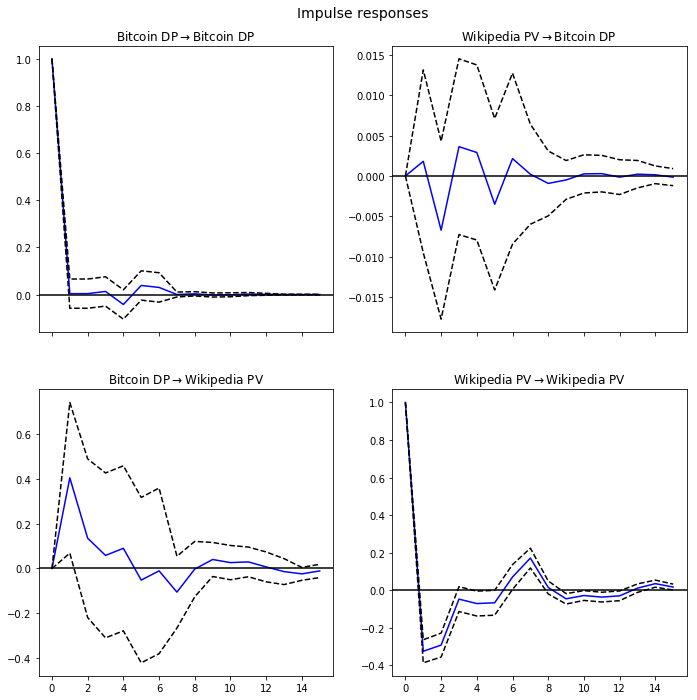

In [40]:
irf_2.plot()
plt.show()

With ortogonalization: Order 1: Bitcoin DP - Wikipedia PV

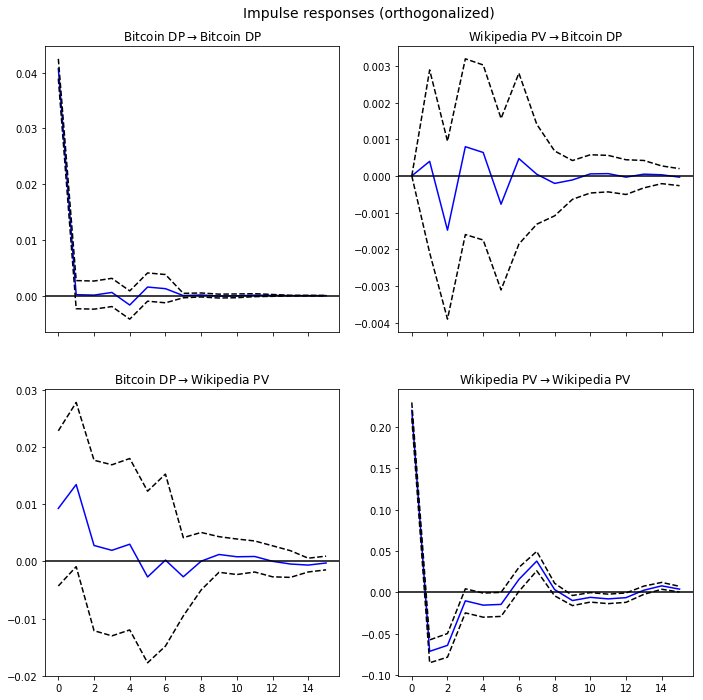

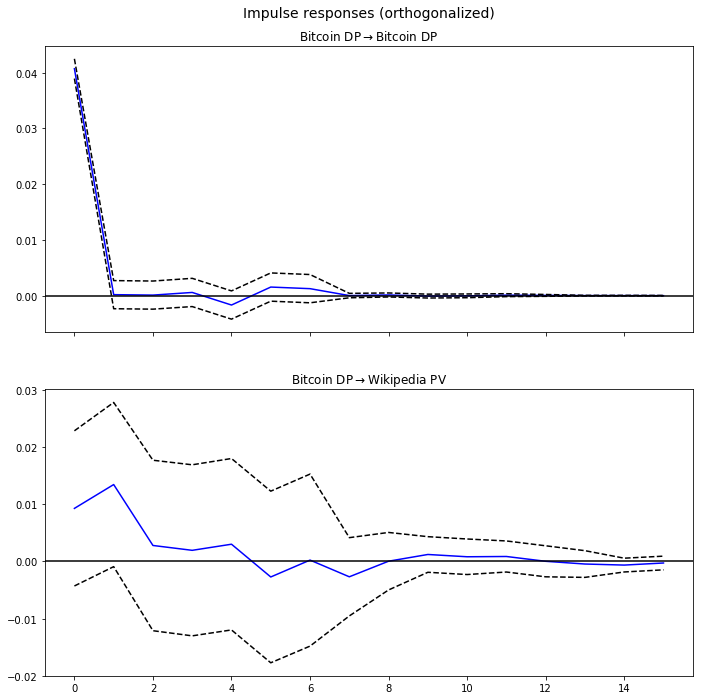

In [41]:
irf_2.plot(orth=True)
irf_2.plot(orth=True, impulse="Bitcoin DP")
plt.show()

With orthogonalization: Order 2: Wikipedia PV - Bitcoin DP

In [42]:
cols_2 = wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff.columns.tolist()
cols_2

['Bitcoin DP', 'Wikipedia PV']

In [43]:
cols_2 = cols_2[-1:] + cols_2[:-1]
cols_2

['Wikipedia PV', 'Bitcoin DP']

In [44]:
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff_b = wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff[cols_2]
wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff_b.head()

,Wikipedia PV,Bitcoin DP
Date,,
2015-07-02,-0.279050,-0.012028
2015-07-03,-0.165488,0.005407
2015-07-04,0.074220,0.016586
2015-07-05,-0.028915,0.042512
2015-07-06,0.166142,-0.011074


In [45]:
data_2_b = wikipedia_pageviews_log_diff_and_bitcoin_price_log_diff_b
model_2_b = VAR(data_2_b)

In [46]:
results_2_b = model_2_b.fit(maxlags=15, ic='bic')

In [47]:
results_2_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:40:06
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -9.27993
Nobs:                     1012.00    HQIC:                  -9.35832
Log likelihood:           1913.67    FPE:                8.22026e-05
AIC:                     -9.40633    Det(Omega_mle):     8.01307e-05
--------------------------------------------------------------------
Results for equation Wikipedia PV
                     coefficient       std. error           t-stat            prob
----------------------------------------------------------------------------------
const                  -0.004016         0.007055           -0.569           0.569
L1.Wikipedia PV        -0.324379         0.031251          -10.380           0.000
L1.Bitcoin DP           0.403615         0.17

In [48]:
irf_2_b = results_2_b.irf(15)

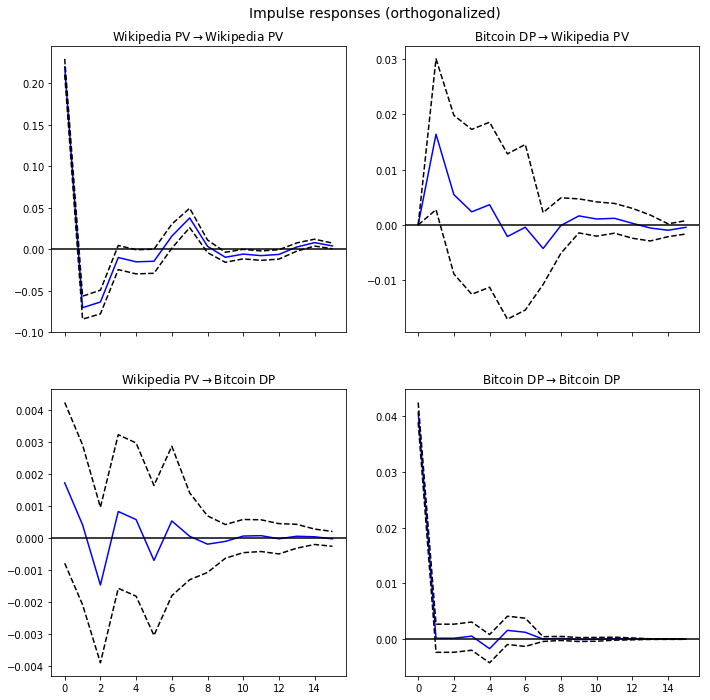

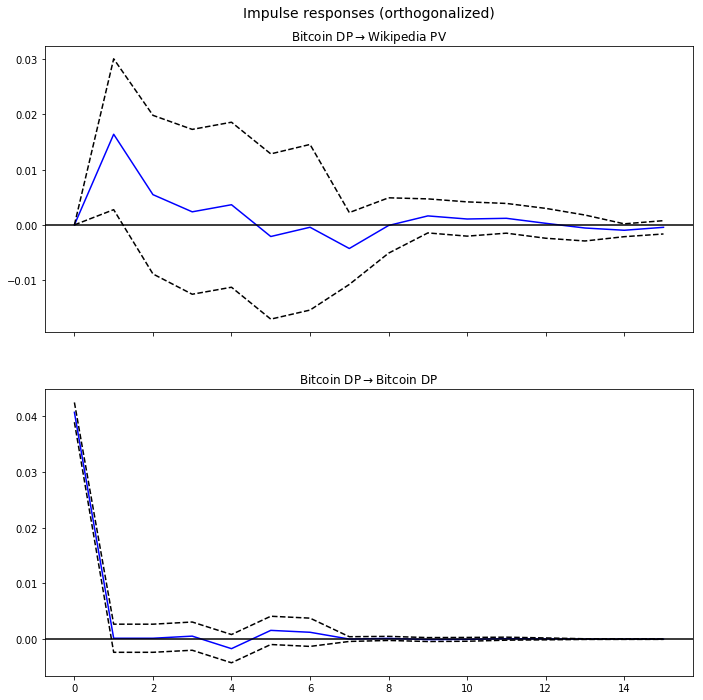

In [49]:
irf_2_b.plot(orth=True)
irf_2_b.plot(orth=True, impulse="Bitcoin DP")
plt.show()

## Granger Causality Test

In [50]:
results_2.test_causality("Bitcoin DP", "Wikipedia PV", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         0.419182         2.103115            0.867  (6, 1998)
H_0: ['Wikipedia PV'] do not Granger-cause Bitcoin DP
Conclusion: fail to reject H_0 at 5.00% significance level


{'conclusion': 'fail to reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.8666698154471254,
 'signif': 0.05,
 'statistic': 0.41918211284677964}

In [51]:
results_2.test_causality("Wikipedia PV", "Bitcoin DP", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value         df
--------------------------------------------------------------
         2.384888         2.103115            0.027  (6, 1998)
H_0: ['Bitcoin DP'] do not Granger-cause Wikipedia PV
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 2.103114521247186,
 'df': (6, 1998),
 'pvalue': 0.026735074054717482,
 'signif': 0.05,
 'statistic': 2.3848877537899043}

## 3. Control Variable: Google SV Worldwide and Bitcoin WAP

Import used data:

In [52]:
bitcoin_weekly_price = pd.DataFrame.from_csv("Bitcoin Weekly Price Data.csv")
google_queries = pd.DataFrame.from_csv("Google Trends Relative Search Volume Worldwide.csv")

## Calculate first log differences

In [53]:
bitcoin_weekly_price_series = pd.Series(data=bitcoin_weekly_price["Weekly Average Price"])
bitcoin_weekly_price_series.head()

0     96.677143
1    133.834286
2    121.818571
3    113.905714
4    113.572857
Name: Weekly Average Price, dtype: float64

In [54]:
bitcoin_weekly_price_series_log = bitcoin_weekly_price_series.apply(np.log)
bitcoin_weekly_price_series_log_diff = bitcoin_weekly_price_series_log.diff()
bitcoin_weekly_price_series_log_diff = bitcoin_weekly_price_series_log_diff.drop(0)
bitcoin_weekly_price_series_log_diff.head()

1    0.325225
2   -0.094070
3   -0.067162
4   -0.002926
5    0.068116
Name: Weekly Average Price, dtype: float64

In [55]:
google_queries_series = pd.Series(data=google_queries["Relative Search Volume Worldwide"])
google_queries_series.head()

0    6
1    3
2    3
3    3
4    2
Name: Relative Search Volume Worldwide, dtype: int64

In [56]:
google_queries_series_log = google_queries_series.apply(np.log)
google_queries_series_log_diff = google_queries_series_log.diff()
google_queries_series_log_diff = google_queries_series_log_diff.drop(0)
google_queries_series_log_diff.head()

1   -0.693147
2    0.000000
3    0.000000
4   -0.405465
5    0.000000
Name: Relative Search Volume Worldwide, dtype: float64

Join the two dataframes:

In [57]:
a = {'Date': bitcoin_weekly_price["Date"] , 'Bitcoin WAP': bitcoin_weekly_price_series_log_diff, "Google SV (Worldwide)" : google_queries_series_log_diff}

In [58]:
google_queries_log_diff_and_bitcoin_price_log_diff = pd.DataFrame(a)
google_queries_log_diff_and_bitcoin_price_log_diff = google_queries_log_diff_and_bitcoin_price_log_diff.drop(0)
google_queries_log_diff_and_bitcoin_price_log_diff["Date"] = pd.to_datetime(google_queries_log_diff_and_bitcoin_price_log_diff["Date"])
google_queries_log_diff_and_bitcoin_price_log_diff = google_queries_log_diff_and_bitcoin_price_log_diff.set_index("Date")
google_queries_log_diff_and_bitcoin_price_log_diff.head()

,Bitcoin WAP,Google SV (Worldwide)
Date,,
2013-04-21,0.325225,-0.693147
2013-04-28,-0.094070,0.000000
2013-05-05,-0.067162,0.000000
2013-05-12,-0.002926,-0.405465
2013-05-19,0.068116,0.000000


## Create the VAR Model

In [59]:
data_1 = google_queries_log_diff_and_bitcoin_price_log_diff

In [60]:
model_1 = VAR(data_1)

## Lag order selection

In [61]:
model_1.select_order(15)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -7.313       -7.284    0.0006670       -7.301
1        -7.484      -7.398*    0.0005619      -7.450*
2        -7.488       -7.345    0.0005596       -7.431
3       -7.524*       -7.324   0.0005401*       -7.443
4        -7.502       -7.245    0.0005520       -7.398
5        -7.502       -7.187    0.0005522       -7.375
6        -7.502       -7.130    0.0005523       -7.352
7        -7.487       -7.059    0.0005603       -7.315
8        -7.468       -6.982    0.0005713       -7.272
9        -7.459       -6.916    0.0005767       -7.240
10       -7.444       -6.844    0.0005852       -7.203
11       -7.435       -6.777    0.0005911       -7.170
12       -7.416       -6.701    0.0006025       -7.128
13       -7.392       -6.621    0.0006170       -7.082
14       -7.368       -6.539    0.0006326       -7.034
15       -

{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 1}

In [62]:
results_1 = model_1.fit(maxlags=15, ic='bic')

## Regression Results

Check Coefficients, contemporaneous correlation of residuals,...

In [63]:
results_1.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:40:08
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.34620
Nobs:                     259.000    HQIC:                  -7.39547
Log likelihood:           232.993    FPE:                0.000594022
AIC:                     -7.42860    Det(Omega_mle):     0.000580496
--------------------------------------------------------------------
Results for equation Bitcoin WAP
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.010676         0.006319            1.690           0.092
L1.Bitcoin WAP                   0.271053         0.058169            4.660           0.000
L1.Google 

## Impulse Response Analysis

In [64]:
irf_1 = results_1.irf(5)

Without orthogonalization:

In [65]:
irf_1.plot()

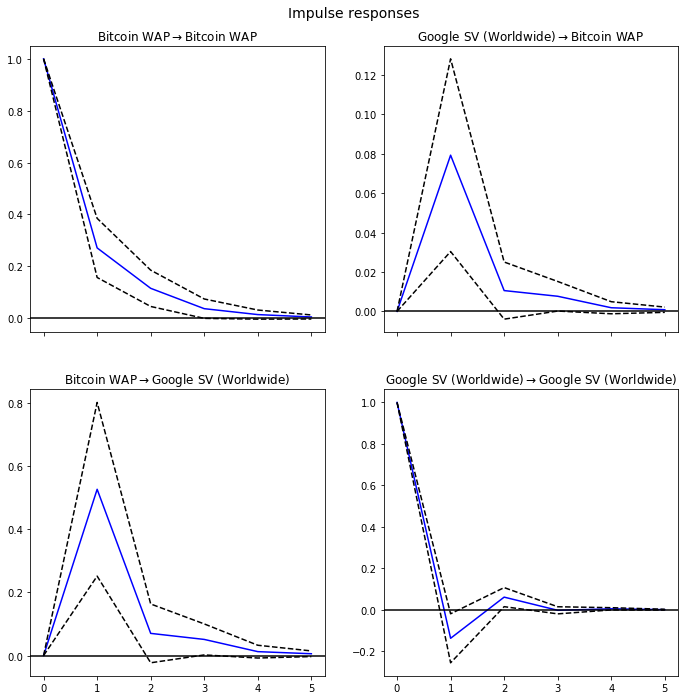

In [66]:
plt.show()

With orthogonalization: Order 1 (Bitcoin WAP - Google SV)

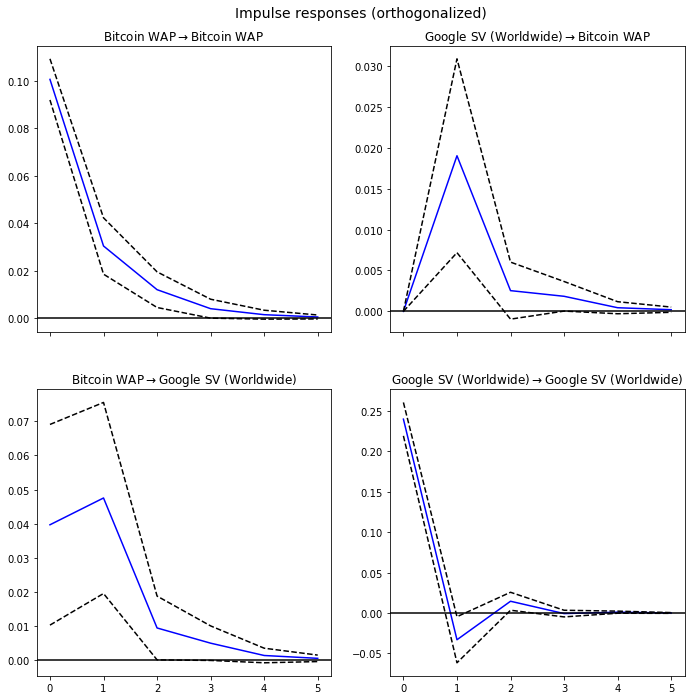

In [67]:
irf_1.plot(orth=True)
plt.show()

With orthogonalization: Order 2 (Google SV - Bitcoin WAP)

In [68]:
cols = google_queries_log_diff_and_bitcoin_price_log_diff.columns.tolist()
cols

['Bitcoin WAP', 'Google SV (Worldwide)']

In [69]:
cols = cols[-1:] + cols[:-1]
cols

['Google SV (Worldwide)', 'Bitcoin WAP']

In [70]:
google_queries_log_diff_and_bitcoin_price_log_diff_b = google_queries_log_diff_and_bitcoin_price_log_diff[cols]
google_queries_log_diff_and_bitcoin_price_log_diff_b.head()

,Google SV (Worldwide),Bitcoin WAP
Date,,
2013-04-21,-0.693147,0.325225
2013-04-28,0.000000,-0.094070
2013-05-05,0.000000,-0.067162
2013-05-12,-0.405465,-0.002926
2013-05-19,0.000000,0.068116


In [71]:
data_1_b = google_queries_log_diff_and_bitcoin_price_log_diff_b
model_1_b = VAR(data_1_b)

In [72]:
results_1_b = model_1_b.fit(maxlags=15, ic='bic')

In [73]:
results_1_b.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, May, 2018
Time:                     13:40:10
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -7.34620
Nobs:                     259.000    HQIC:                  -7.39547
Log likelihood:           232.993    FPE:                0.000594022
AIC:                     -7.42860    Det(Omega_mle):     0.000580496
--------------------------------------------------------------------
Results for equation Google SV (Worldwide)
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.001676         0.015266           -0.110           0.913
L1.Google SV (Worldwide)        -0.137758         0.060306           -2.284           0.023


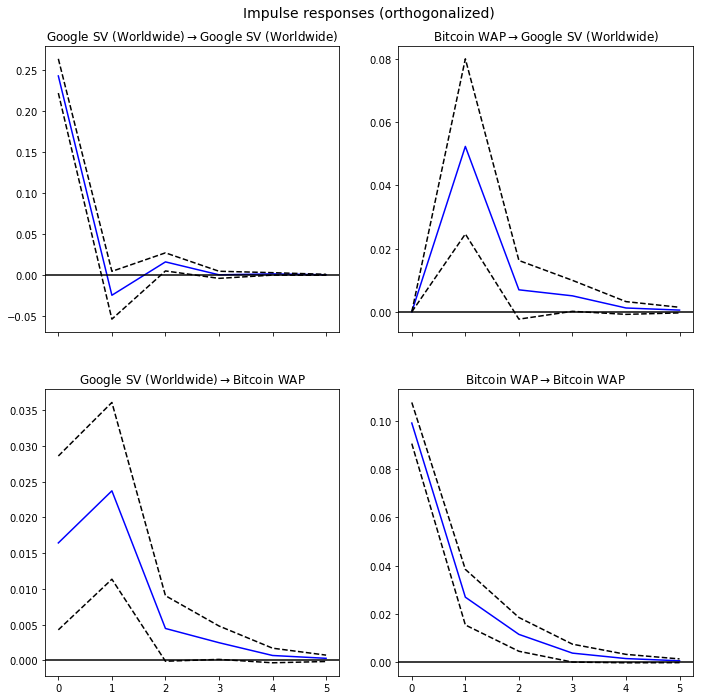

In [74]:
irf_1_b = results_1_b.irf(5)
irf_1_b.plot(orth=True)
plt.show()

## Granger Causality Test

In [75]:
results_1.test_causality("Bitcoin WAP", "Google SV (Worldwide)", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
        10.099421         3.859685            0.002  (1, 512)
H_0: ['Google SV (Worldwide)'] do not Granger-cause Bitcoin WAP
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.0015727659747370314,
 'signif': 0.05,
 'statistic': 10.099420702117154}

In [76]:
results_1.test_causality("Google SV (Worldwide)", "Bitcoin WAP", kind="f")

Granger causality f-test
   Test statistic   Critical Value          p-value        df
-------------------------------------------------------------
        14.080952         3.859685            0.000  (1, 512)
H_0: ['Bitcoin WAP'] do not Granger-cause Google SV (Worldwide)
Conclusion: reject H_0 at 5.00% significance level


{'conclusion': 'reject',
 'crit_value': 3.8596850369982239,
 'df': (1, 512),
 'pvalue': 0.00019514368103254839,
 'signif': 0.05,
 'statistic': 14.080952032640184}